## Random Forest with 5 positions

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, col

import matplotlib.pyplot as plt

In [2]:
# Build the SparkSession
spark = SparkSession.builder \
   .master("local") \
   .appName("DDAM Project") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()
   
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/12 17:52:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Import

In [4]:
df_boxscore = spark.read.csv("/Users/davidepiccoli/Desktop/ddam/DDAM project/df_boxscore_clean_357.csv", header=True, inferSchema=True)

In [5]:
print(df_boxscore.count())

539171


In [6]:
# Renaming
df_boxscore = df_boxscore.withColumnRenamed("pos_clean", "Position")

In [7]:
df_boxscore.printSchema()

root
 |-- playerName: string (nullable = true)
 |-- FGA: integer (nullable = true)
 |-- 3P: integer (nullable = true)
 |-- 3PA: integer (nullable = true)
 |-- FTA: integer (nullable = true)
 |-- ORB: integer (nullable = true)
 |-- DRB: integer (nullable = true)
 |-- AST: integer (nullable = true)
 |-- STL: integer (nullable = true)
 |-- BLK: integer (nullable = true)
 |-- TOV: integer (nullable = true)
 |-- PF: integer (nullable = true)
 |-- PTS: integer (nullable = true)
 |-- +/-: integer (nullable = true)
 |-- isStarter: integer (nullable = true)
 |-- seasonStartYear: integer (nullable = true)
 |-- isRegular: integer (nullable = true)
 |-- pos7: string (nullable = true)
 |-- Ht: double (nullable = true)
 |-- Wt: double (nullable = true)
 |-- MP_seconds: integer (nullable = true)
 |-- pos3: string (nullable = true)
 |-- pos5: string (nullable = true)
 |-- EFG: double (nullable = true)
 |-- TO_ratio: double (nullable = true)



# Position one-hot-encoding

In [8]:
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="pos5", outputCol="PosNum", handleInvalid="skip")

df_boxscore = indexer.fit(df_boxscore).transform(df_boxscore)

In [9]:
from pyspark.ml.feature import OneHotEncoder
onehotencoder_embarked_vector = OneHotEncoder(inputCol="PosNum", outputCol="PosVec")
df_boxscore = onehotencoder_embarked_vector.fit(df_boxscore).transform(df_boxscore)
df_boxscore.show()

23/12/12 17:55:03 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+----+------------------+-----+----------+----+----+-------------------+-------------------+------+-------------+
|        playerName|FGA| 3P|3PA|FTA|ORB|DRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|seasonStartYear|isRegular|pos7|                Ht|   Wt|MP_seconds|pos3|pos5|                EFG|           TO_ratio|PosNum|       PosVec|
+------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+----+------------------+-----+----------+----+----+-------------------+-------------------+------+-------------+
|Corliss Williamson| 11|  0|  0|  0|  1|  3|  4|  1|  1|  4|  5| 14| -2|        1|           1996|        1|   F|            200.66|245.0|      2240|   F|   F| 0.6363636363636364|0.21052631578947367|   1.0|(4,[1],[1.0])|
|    Olden Polynice|  4|  0|  0|  4|  2|  5|  3|  1|  0|  4|  3|  1|-12|        1|           1996|        1| C-F|   

In [10]:
column2drop = ('playerName', 'game_id', 'teamName', 'seasonStartYear', 'Ht', 'Pos', 'Position', 'Wt', 'feet', 'inches', 'pos3', 'pos7', 'pos5')
df_boxscore = df_boxscore.drop(*column2drop)

In [11]:
# removing correlated features
too_correlated = ('FG', 'FT', 'TRB', 'TSP')
df_boxscore = df_boxscore.drop(*too_correlated)

In [12]:
df_boxscore.printSchema()

root
 |-- FGA: integer (nullable = true)
 |-- 3P: integer (nullable = true)
 |-- 3PA: integer (nullable = true)
 |-- FTA: integer (nullable = true)
 |-- ORB: integer (nullable = true)
 |-- DRB: integer (nullable = true)
 |-- AST: integer (nullable = true)
 |-- STL: integer (nullable = true)
 |-- BLK: integer (nullable = true)
 |-- TOV: integer (nullable = true)
 |-- PF: integer (nullable = true)
 |-- PTS: integer (nullable = true)
 |-- +/-: integer (nullable = true)
 |-- isStarter: integer (nullable = true)
 |-- isRegular: integer (nullable = true)
 |-- MP_seconds: integer (nullable = true)
 |-- EFG: double (nullable = true)
 |-- TO_ratio: double (nullable = true)
 |-- PosNum: double (nullable = false)
 |-- PosVec: vector (nullable = true)



# Data understanding

In [13]:
# Is data balanced?
categorical_columns = ['PosNum']

for column in categorical_columns:
    distinct_values = df_boxscore.groupBy(column).count().collect()
    print(f"Distinct values and frequencies in {column}:")
    for row in distinct_values:
        value = row[column]
        frequency = row["count"]
        print(f"{value}: {frequency}")
    print()

Distinct values and frequencies in PosNum:
0.0: 186058
1.0: 149152
4.0: 59119
3.0: 70249
2.0: 74593



# Data preparation

In [14]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [15]:
num_col = [item[0] for item in df_boxscore.dtypes if not item[1].startswith('string')]
num_col.remove("PosNum")
num_col.remove("PosVec")
print(num_col)

['FGA', '3P', '3PA', 'FTA', 'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', '+/-', 'isStarter', 'isRegular', 'MP_seconds', 'EFG', 'TO_ratio']


In [16]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

# Selezionare tutte le colonne
selected_columns = num_col

# Creare un VectorAssembler
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")

# Applicare l'assemblatore
output_dataset = assembler.transform(df_boxscore)

# Creare uno scaler per normalizzare le features
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")

# Applicare lo scaler
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
output_dataset.show(5)

+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------+----------+-------------------+-------------------+------+-------------+--------------------+--------------------+
|FGA| 3P|3PA|FTA|ORB|DRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|isRegular|MP_seconds|                EFG|           TO_ratio|PosNum|       PosVec|            features|     features_scaled|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------+----------+-------------------+-------------------+------+-------------+--------------------+--------------------+
| 11|  0|  0|  0|  1|  3|  4|  1|  1|  4|  5| 14| -2|        1|        1|      2240| 0.6363636363636364|0.21052631578947367|   1.0|(4,[1],[1.0])|[11.0,0.0,0.0,0.0...|[0.25,0.0,0.0,0.0...|
|  4|  0|  0|  4|  2|  5|  3|  1|  0|  4|  3|  1|-12|        1|        1|      1894|                0.0|0.31347962382445144|   2.0|(4,[2],[1.0])|[4.0,0.0,0.0,4.0,...|[0.09090909090909...|
| 13|  1|  2|  2|  0|  2|  5|  1|  1|  2|  2| 17| -7|       

In [17]:
classificationData = output_dataset.select("features_scaled", "PosNum")

classificationData.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|features_scaled                                                                                                                                                                                                                                                                          |PosNum|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|[0.25,0.0,0.0,0.0,0.05555555555555555,0.13043478260869565,0.16,0.1,0.07692307692307693,0.3333333333333333,0.7142857142857142,0

In [18]:
(trainingData, testData) = classificationData.randomSplit([0.7, 0.3],seed=1)

In [19]:
# Validation split
(trainingData, valData) = trainingData.randomSplit([0.8, 0.2],seed=1)

In [20]:
trainingData.show(100, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|features_scaled                                                                                                                                                                                                                          |PosNum|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|(18,[0,1,2,3,4,5,11,12,15,16],[0.06818181818181818,0.07142857142857142,0.041666666666666664,0.05128205128205128,0.05555555555555555,0.043478260869565216,0.09999999999999999,0.5614035087719298,0.02539763981528989,0.7777777777777778]) |0.0   |
|(18,[0,1,2,3,4,5,11,12,15,1

# Random forest

In [22]:
import random
import itertools

In [24]:
def plot_importance(importance):
    keys = importance.keys()
    values = importance.values()

    # Plot the dictionary
    plt.figure(figsize=(17,5))
    plt.bar(keys, values)
    plt.xlabel("Keys")
    plt.ylabel("Values")
    plt.title("Dictionary Plot")
    plt.show()

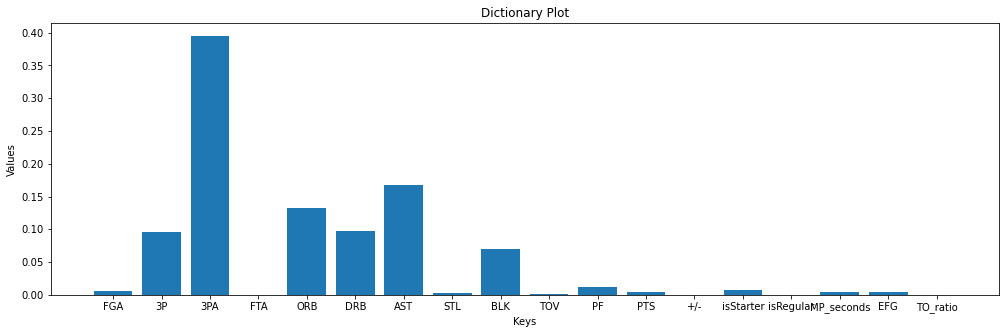

With parameters {'numTrees': 25, 'maxDepth': 6, 'maxBins': 16, 'impurity': 'entropy'}


Validation accuracy = 0.48719001695633746


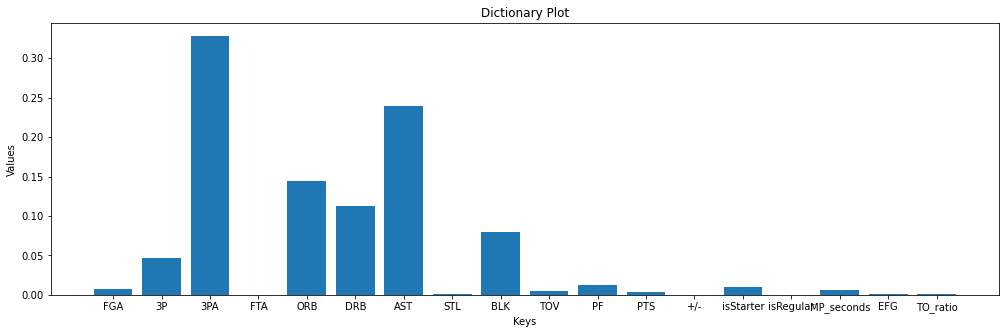

With parameters {'numTrees': 25, 'maxDepth': 6, 'maxBins': 32, 'impurity': 'gini'}


Validation accuracy = 0.48916384061042817


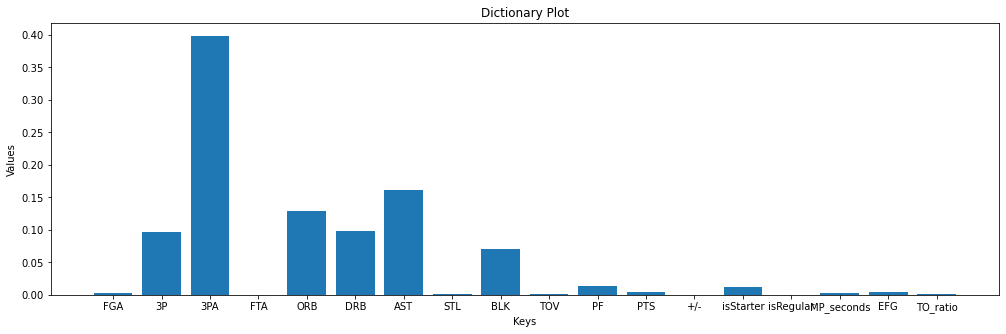

With parameters {'numTrees': 50, 'maxDepth': 6, 'maxBins': 32, 'impurity': 'entropy'}


Validation accuracy = 0.48858096651123356


23/12/12 18:05:41 WARN DAGScheduler: Broadcasting large task binary with size 1257.0 KiB
23/12/12 18:05:47 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


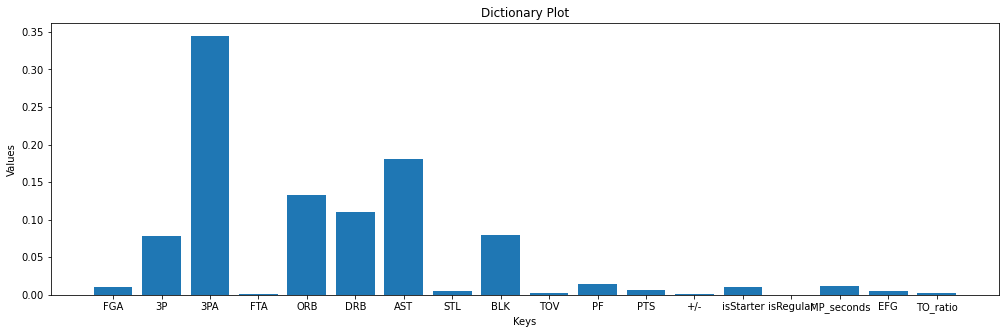

With parameters {'numTrees': 25, 'maxDepth': 9, 'maxBins': 32, 'impurity': 'entropy'}


23/12/12 18:05:54 WARN DAGScheduler: Broadcasting large task binary with size 1678.6 KiB


Validation accuracy = 0.5017088808817295


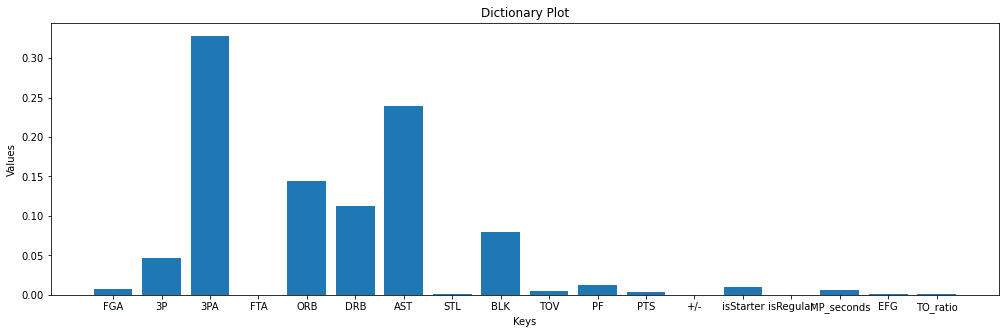

With parameters {'numTrees': 25, 'maxDepth': 6, 'maxBins': 64, 'impurity': 'gini'}


Validation accuracy = 0.4892433234421365


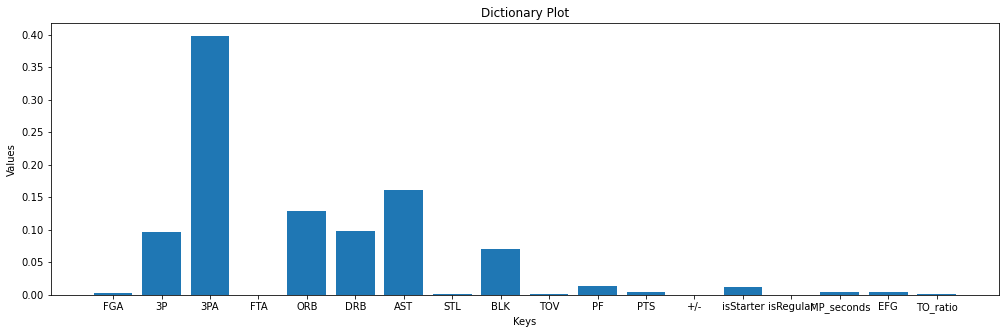

With parameters {'numTrees': 50, 'maxDepth': 6, 'maxBins': 64, 'impurity': 'entropy'}


Validation accuracy = 0.48887240356083084


23/12/12 18:08:25 WARN DAGScheduler: Broadcasting large task binary with size 1236.7 KiB
23/12/12 18:08:34 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/12 18:08:44 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/12/12 18:08:55 WARN DAGScheduler: Broadcasting large task binary with size 1427.1 KiB


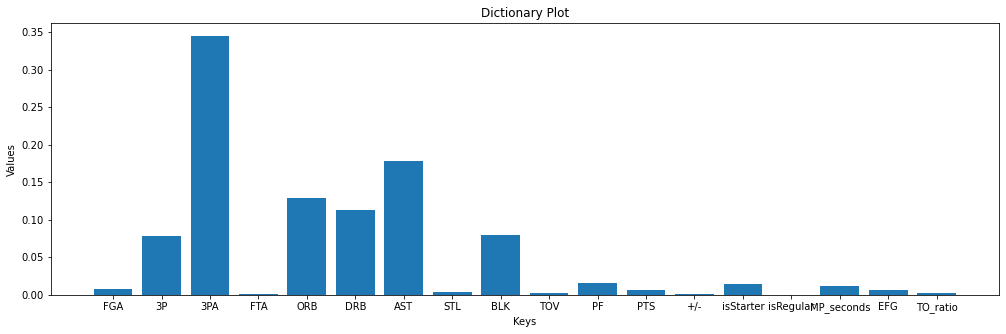

With parameters {'numTrees': 50, 'maxDepth': 9, 'maxBins': 64, 'impurity': 'entropy'}


23/12/12 18:08:58 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


Validation accuracy = 0.5021990250105978


23/12/12 18:09:39 WARN DAGScheduler: Broadcasting large task binary with size 1258.0 KiB
23/12/12 18:09:43 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


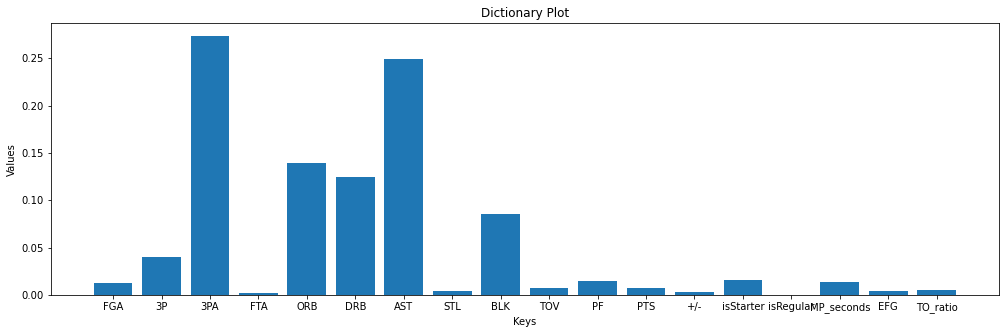

With parameters {'numTrees': 25, 'maxDepth': 9, 'maxBins': 64, 'impurity': 'gini'}


23/12/12 18:09:49 WARN DAGScheduler: Broadcasting large task binary with size 1828.5 KiB


Validation accuracy = 0.5021195421788893


23/12/12 18:10:43 WARN DAGScheduler: Broadcasting large task binary with size 1233.4 KiB
23/12/12 18:10:52 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/12 18:11:02 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/12/12 18:11:14 WARN DAGScheduler: Broadcasting large task binary with size 1427.8 KiB


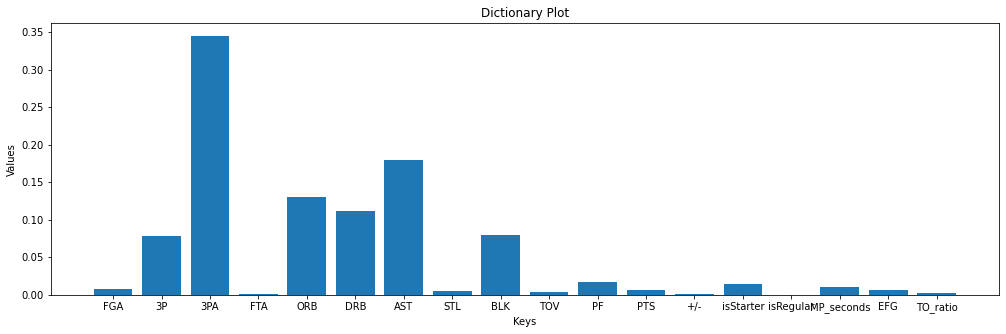

With parameters {'numTrees': 50, 'maxDepth': 9, 'maxBins': 16, 'impurity': 'entropy'}


23/12/12 18:11:16 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


Validation accuracy = 0.5025831920305214


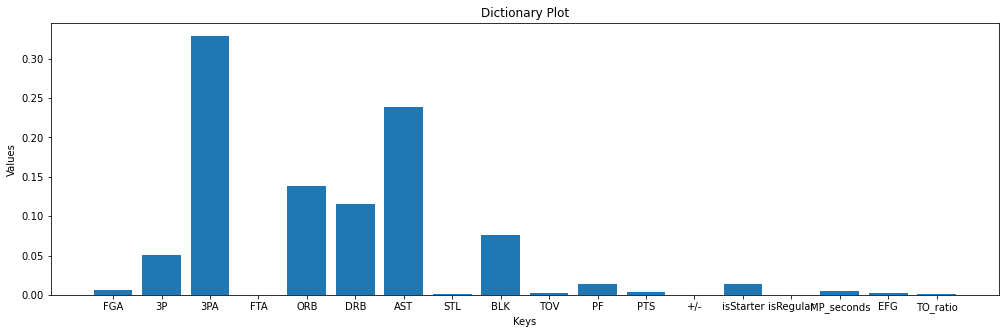

With parameters {'numTrees': 50, 'maxDepth': 6, 'maxBins': 16, 'impurity': 'gini'}


Validation accuracy = 0.48993217465027555


23/12/12 18:13:06 WARN DAGScheduler: Broadcasting large task binary with size 1236.7 KiB
23/12/12 18:13:14 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/12 18:13:24 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/12/12 18:13:35 WARN DAGScheduler: Broadcasting large task binary with size 1394.9 KiB


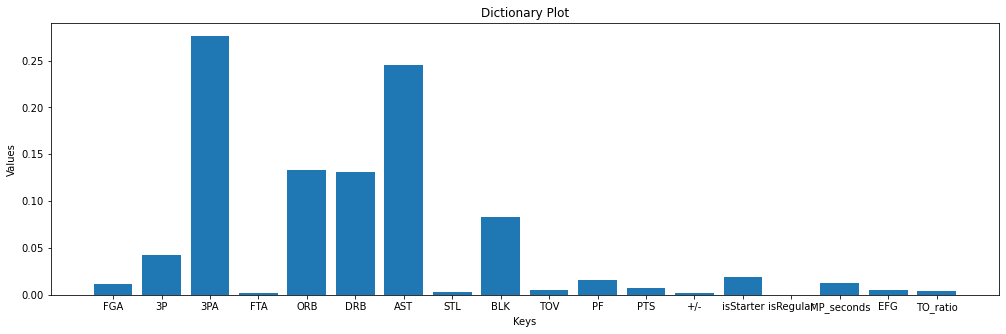

With parameters {'numTrees': 50, 'maxDepth': 9, 'maxBins': 64, 'impurity': 'gini'}


23/12/12 18:13:38 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


Validation accuracy = 0.5033382789317508


23/12/12 18:14:30 WARN DAGScheduler: Broadcasting large task binary with size 1235.2 KiB
23/12/12 18:14:39 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/12 18:14:48 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/12/12 18:14:58 WARN DAGScheduler: Broadcasting large task binary with size 1402.3 KiB


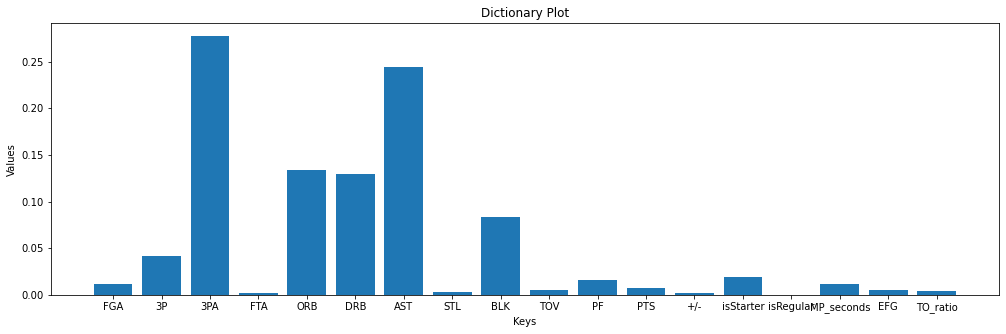

With parameters {'numTrees': 50, 'maxDepth': 9, 'maxBins': 32, 'impurity': 'gini'}


23/12/12 18:15:00 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


Validation accuracy = 0.5030600890207715


In [25]:
# random search
hyperparameters = {
    'numTrees': [25, 50],
    'maxDepth': [6, 9],
    'maxBins' : [16, 32, 64],
    'impurity' : ['gini', 'entropy']
}

number_of_combinations = 12
random_combinations = random.sample(list(itertools.product(*hyperparameters.values())), number_of_combinations)

for combo in random_combinations:
    param_dict = dict(zip(hyperparameters.keys(), combo))
    
    rf = RandomForestClassifier(labelCol="PosNum", featuresCol="features_scaled", numTrees=param_dict['numTrees'], impurity=param_dict['impurity'], maxDepth=param_dict['maxDepth'], maxBins=param_dict['maxBins'])

    rf = rf.fit(trainingData)

    importance = {}
    featureImportances = list(rf.featureImportances)

    for i,e in enumerate(featureImportances):
        importance[num_col[i]] = e
    
    plot_importance(importance)

    # Make predictions
    predictions = rf.transform(valData)

    # Select (prediction, true label) and compute test error
    evaluator = MulticlassClassificationEvaluator(labelCol="PosNum"
                                                , predictionCol="prediction"
                                                , metricName="accuracy")

    print('With parameters', param_dict)
    accuracy = evaluator.evaluate(predictions)
    print('Validation accuracy =', accuracy)

In [26]:
rf = RandomForestClassifier(labelCol="PosNum", featuresCol="features_scaled", numTrees= 50, maxDepth= 9, maxBins= 64, impurity= 'gini')

rf = rf.fit(trainingData)

23/12/12 18:30:28 WARN DAGScheduler: Broadcasting large task binary with size 1236.7 KiB
23/12/12 18:30:37 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/12 18:30:48 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/12/12 18:31:01 WARN DAGScheduler: Broadcasting large task binary with size 1394.9 KiB


In [27]:
rf.featureImportances

SparseVector(18, {0: 0.0116, 1: 0.0421, 2: 0.2762, 3: 0.0019, 4: 0.1335, 5: 0.1308, 6: 0.2452, 7: 0.0034, 8: 0.0832, 9: 0.0052, 10: 0.0158, 11: 0.0076, 12: 0.0024, 13: 0.0186, 14: 0.0003, 15: 0.0122, 16: 0.0056, 17: 0.0044})

In [28]:
importance = {}
featureImportances = list(rf.featureImportances)

for i,e in enumerate(featureImportances):
    importance[num_col[i]] = e

importance

{'FGA': 0.011605341971312112,
 '3P': 0.04211963520974056,
 '3PA': 0.2761891317141518,
 'FTA': 0.0018950225673161703,
 'ORB': 0.13346634362491133,
 'DRB': 0.1307983968018422,
 'AST': 0.24515865244285023,
 'STL': 0.0034373704040282166,
 'BLK': 0.08321889619077849,
 'TOV': 0.005204538331815186,
 'PF': 0.015840744476556316,
 'PTS': 0.007579537896539652,
 '+/-': 0.002396135780407019,
 'isStarter': 0.018628993979531397,
 'isRegular': 0.00025702290461943517,
 'MP_seconds': 0.012245285664506743,
 'EFG': 0.005561104353497996,
 'TO_ratio': 0.004397845685595193}